1. 模型：transformer是由编码器和解码器组成的
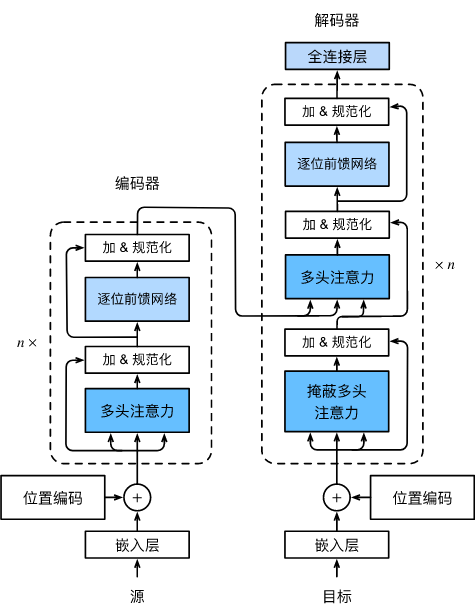

In [1]:
import math
import pandas as pd
import torch
from torch import nn
import dltools

In [2]:
# 基于位置的前馈网络
# （Feed-Forward Net,FFN）
class PositionWiseFFN(nn.Module): 
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,**kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(6, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 6))).shape

torch.Size([2, 3, 8])

In [4]:
# 残差连接和层规范化
# 这种残差结构能够很好的消除层数加深所带来的信息损失问题。
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))


layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
# 现在我们可以使用残差连接和层规范化来实现AddNorm类。暂退法也被作为正则化方法使用。
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [6]:
# 残差连接要求两个输入的形状相同，以便加法操作后输出张量的形状相同
add_norm = AddNorm([6, 8], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 6, 8)), torch.ones((2, 6, 8)))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]],
       grad_fn=<NativeLayerNormBackward0>)

In [7]:
# 编码器
class EncoderBlock(nn.Module):
    """transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = dltools.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout,use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))


In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [30]:
# transformer编码器
class TransformerEncoder(dltools.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = dltools.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),EncoderBlock(key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens,num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # embedding matrix的初始化方式是xavier init，这种方式的方差是1/embedding size，因此乘以embedding size的开方使得embedding matrix的方差是1，在这个scale下可能更有利于embedding matrix的收敛。
        # 然后再与位置编码相加。
#         print(X)
#         print(X.shape)
#         print(self.embedding(X))
#         print(self.embedding(X).shape)
#         print(self.embedding(X) * math.sqrt(self.num_hiddens))
#         print((self.embedding(X) * math.sqrt(self.num_hiddens)).shape)
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [10]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])
torch.Size([2, 100])
tensor([[[-0.4288,  0.2751, -1.1848,  ..., -0.4788,  0.9977, -1.0763],
         [-0.4288,  0.2751, -1.1848,  ..., -0.4788,  0.9977, -1.0763],
         [-0.4288,  0.2751, -1.1848,  ..., -0.4788,  0.9977, -1.0763],
         ...,
         [-0.4288,  0.2751, -1.1848,  ..., -0.4788,  0.9977

torch.Size([2, 100, 24])

In [53]:
# 解码器
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = dltools.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = dltools.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        print("state数据情况：")
        if state[2][0] is not None:
            print(state[2][0].shape)
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [54]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

state数据情况：


torch.Size([2, 100, 24])

In [55]:
# transformer解码器部分
class TransformerDecoder(dltools.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = dltools.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),DecoderBlock(key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens,num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

**************************************************************
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([25, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([64, 10, 32])
state数据情况：
state数据情况：
torch.Size([25, 10, 32

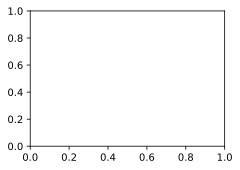

In [56]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 3, dltools.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = dltools.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens,norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,num_layers, dropout)
# print(encoder)
print("**************************************************************")
# print(decoder)
net = dltools.EncoderDecoder(encoder, decoder)
dltools.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [54]:
# 训练完成后测试模型
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = dltools.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',f'bleu {dltools.bleu(translation, fra, k=2):.3f}')

tensor([[9, 4, 3, 1, 1, 1, 1, 1, 1, 1]])
torch.Size([1, 10])
tensor([[[-7.2648e-01,  1.0787e+00, -7.3592e-01, -2.3071e+00,  3.7606e-01,
          -1.0513e+00, -3.4482e+00,  6.0120e-01,  8.3126e-01, -9.0739e-01,
           2.4083e-01, -4.1654e-01,  4.8700e-01,  9.2818e-01,  6.9815e-01,
           1.6399e+00,  5.1396e-01,  1.1439e+00,  8.9232e-02,  9.1544e-01,
           2.0347e+00, -1.1585e+00,  9.5321e-01,  6.0233e-01,  5.9116e-01,
           6.7708e-01, -1.6284e+00, -6.7772e-01,  5.9417e-01, -1.0498e+00,
          -2.2200e+00, -7.1444e-01],
         [-1.3035e+00, -1.0355e+00,  9.9648e-01,  6.1514e-01, -1.1657e+00,
          -6.1070e-01, -7.0387e-02,  4.0725e-01, -8.4140e-02,  3.2807e-01,
           2.3384e-02, -1.5481e+00, -4.5453e-02, -4.3161e-01, -1.9140e-01,
          -1.9905e-01, -1.7972e-01, -2.5504e+00,  3.7135e-01, -1.0158e+00,
          -1.8054e+00, -9.5953e-01,  3.0282e-01, -7.0468e-01, -1.4381e+00,
           1.1039e-02, -1.5653e+00, -3.2289e-01, -8.9210e-01,  1.5514e-01,
  